# Photonic spin selector optimized via direct binary search (DBS)

This notebook demonstrates how to design a photonic spin selector (PSS), inspired by the integrated nanophotonic alkali-vapor magnetometer reported by `Sebbag, Y., Talker, E., Naiman, A. et al. Demonstration of an integrated nanophotonic chip-scale alkali vapor magnetometer using inverse design. Light Sci Appl 10, 54 (2021).` [DOI: 10.1038/s41377-021-00499-5](https://doi.org/10.1038/s41377-021-00499-5). In that work, an inverse-designed nanophotonic structure is used to spatially separate right- and left-circularly polarized light into two distinct waveguide outputs, enabling on-chip detection of magnetically induced polarization changes in an atomic vapor without relying on conventional free-space polarization optics.

We focus exclusively on the photonic design problem: modeling the sub-wavelength pixelated PSS geometry, launching circularly polarized free-space excitation, and evaluating how efficiently opposite photon spin states are routed into different waveguides. The device consists of a circular design region with a radius of 1.8 µm, discretized into subwavelength binary pixels that can be either silicon nitride or air. For each pixel configuration, a 3D FDTD simulation is used to evaluate the polarization-dependent transmission into the left and right waveguides. A figure of merit is defined to maximize coupling of right-circularly polarized light into one waveguide and left-circularly polarized light into the other, while suppressing cross-coupling. The optimization is performed using a direct binary search (DBS) algorithm, which iteratively flips individual pixels and retains changes only when the figure of merit improves. 

<center><img src="img/spin_selector.png" alt="schematic"  width="400"/></center>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web

## Simulation Setup

The PPS is designed to operate at the wavelength of 780 nm.

In [2]:
lda0 = 0.78  # Simulation wavelength
freq0 = td.C_0 / lda0  # Simulation frequency
fwidth = freq0 / 10  # Source frequency width

The design region is a circular region with a radius of 1.8 µm. It is connected to single mode SiN waveguides with a width of 450 nm and a thickness of 250 nm. The BOX layer has a thickness of 2 µm. 

Since we are focusing on a single wavelength, all materials are modelled as nondispersive. 

In [3]:
h_wg = 0.25  # Waveguide thickness
w_wg = 0.45  # Waveguide width
r = 1.8  # Radius of the design region
h_box = 2  # Box layer thickness

# Define the materials
SiN = td.Medium.from_nk(n=2.0255, k=0, freq=freq0)
Si = td.Medium.from_nk(n=3.4945, k=0, freq=freq0)
SiO2 = td.Medium.from_nk(n=1.4537, k=0, freq=freq0)

Next we define the static components of the simulation, which includes the SiN waveguides, BOX layer, Si substrate, and two [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) placed on the two waveguides to measure transmission power.

In [4]:
inf_eff = 1e2  # Effective infinity

# Define the SiN waveguides connected to the design region
waveguide_left = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -w_wg / 2, 0), rmax=(-r, w_wg / 2, h_wg)),
    medium=SiN,
)

waveguide_right = td.Structure(
    geometry=td.Box.from_bounds(rmin=(r, -w_wg / 2, 0), rmax=(inf_eff, w_wg / 2, h_wg)),
    medium=SiN,
)

# Define the SiO2 box and substrate
box = td.Structure(
    geometry=td.Box.from_bounds(rmin=(-inf_eff, -inf_eff, -h_box), rmax=(inf_eff, inf_eff, 0)),
    medium=SiO2,
)

substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -h_box)
    ),
    medium=Si,
)

# Define the mode monitors
mode_spec = td.ModeSpec(num_modes=1, target_neff=2)
mode_monitor_left = td.ModeMonitor(
    center=(-r - lda0 / 2, 0, h_wg / 2),
    size=(0, 4 * w_wg, 5 * h_wg),
    freqs=[freq0],
    mode_spec=mode_spec,
    name="mode_left",
)

mode_monitor_right = td.ModeMonitor(
    center=(r + lda0 / 2, 0, h_wg / 2),
    size=(0, 4 * w_wg, 5 * h_wg),
    freqs=[freq0],
    mode_spec=mode_spec,
    name="mode_right",
)

The design region is circularly discretized into subwavelength pixels. We aim to have a radial pixel size of 120 nm and the azimuthal pixel size of 180 nm. Here we calculate the total number of pixels in the design region.

In [5]:
radial_pixel_size = 0.12
azimutal_pixel_size = 0.18
n_ring = int(round(r / radial_pixel_size))  # Number of rings

n_pixel = 2  # Number of pixels in the first ring

for i in range(n_ring):
    r_in = i * radial_pixel_size
    n_pixel += int(2 * np.pi * r_in / azimutal_pixel_size)

print(f"The total numbre of pixels is {n_pixel}.")

The total numbre of pixels is 435.


Next we create a function to generate the geometry of the pixels in a single ring. 

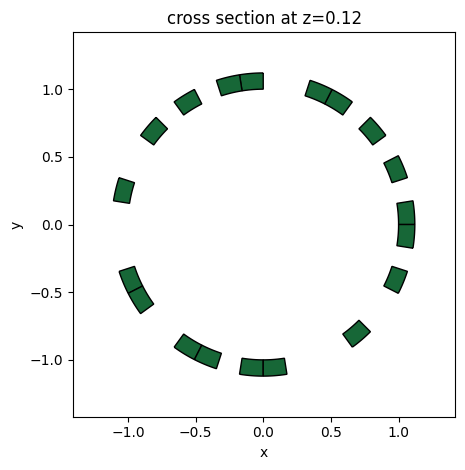

In [6]:
def create_pixelated_ring(r_in: float, pixel_map: list, points_per_pixel: int = 20) -> td.Structure:
    """
    Generates a list of Tidy3D Structures representing an azimuthally pixelated ring.

    Parameters:
        r_in (float): Inner radius.
        pixel_map (list): List of 1s (material) and 0s (no material).
        points_per_pixel (int): Resolution of the arc for each pixel. Higher = smoother.

    Returns:
        geo (td.GeometryGroup): Geometry of the pixelated ring.
    """

    N = len(pixel_map)
    d_theta = 2 * np.pi / N
    r_out = r_in + radial_pixel_size
    geo = 0
    for i, active in enumerate(pixel_map):
        if not active:
            continue

        # Determine angles for this pixel
        theta_start = i * d_theta
        theta_end = (i + 1) * d_theta

        # Generate angular points for smoothness
        # We start at theta_start and end at theta_end
        thetas = np.linspace(theta_start, theta_end, points_per_pixel)

        # Generate vertices
        # Outer arc (Counter-Clockwise)
        x_outer = r_out * np.cos(thetas)
        y_outer = r_out * np.sin(thetas)

        # Inner arc (Clockwise to close the polygon loop)
        x_inner = r_in * np.cos(np.flip(thetas))
        y_inner = r_in * np.sin(np.flip(thetas))

        # Combine into a list of (x,y) tuples
        vertices_outer = np.column_stack((x_outer, y_outer))
        vertices_inner = np.column_stack((x_inner, y_inner))
        vertices = np.vstack((vertices_outer, vertices_inner))

        geo += td.PolySlab(vertices=vertices.tolist(), axis=2, slab_bounds=(0, h_wg))

    return geo


# Create a random pixelated ring to test the function
geo = create_pixelated_ring(
    r_in=1,
    pixel_map=np.random.choice([0, 1], size=40),
)

geo.plot(z=h_wg / 2)
plt.show()

Then we create a function to generate the geometry of the entire design region.

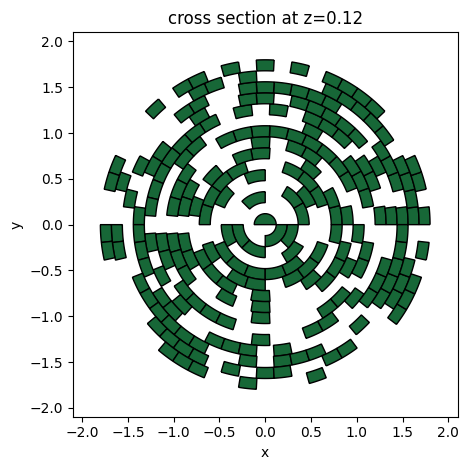

In [7]:
def create_design_region(design_params: np.ndarray):
    """
    Creates the geometry of the design region composed of concentric pixelated rings.

    Parameters:
    design_params (np.ndarray): A flat array of binary values (0 or 1) representing the state of each pixel
                                across all rings. The array is consumed sequentially ring by ring.

    Returns:
    geo (td.GeometryGroup): The geometry object representing the full design region.
    """

    current_index = 0
    geo = 0
    # Iterate through each ring layer
    for i in range(n_ring):
        # Calculate the inner radius of the current ring
        r_in = i * radial_pixel_size

        # Determine the number of azimuthal pixels for the current ring based on its circumference
        if r_in != 0:
            n_ring_pixel = int(2 * np.pi * r_in / azimutal_pixel_size)
        else:
            # Handle the center point (radius 0) with 2 pixels
            n_ring_pixel = 2

        # Extract the subset of design parameters corresponding to the current ring
        pixel_map = design_params[current_index : current_index + n_ring_pixel]
        current_index += n_ring_pixel

        # Create the geometry for the current ring and add it to the total geometry
        geo += create_pixelated_ring(r_in=r_in, pixel_map=pixel_map)

    return geo


# Create a random design region to test the function
design_params = np.random.choice([0, 1], size=n_pixel)
geo = create_design_region(design_params)

geo.plot(z=h_wg / 2)
plt.show()

We create a function to generate two simulations, one with right circular polarization source and one with left circular polarization source, given the design parameters as a 1D array of 0s and 1s. The function will return two simulation objects, one for each polarization.

In [8]:
def make_sims(design_params: np.ndarray):
    """
    Creates two Tidy3D simulations.
    One simulation corresponds to right circularly polarized (RCP) light,
    and the other to left circularly polarized (LCP) light.
    """

    # Create the design region structure
    design_region = td.Structure(geometry=create_design_region(design_params), medium=SiN)

    # Define the X-polarized component of the Gaussian beam source
    gaussian_beam_x = td.GaussianBeam(
        center=(0, 0, h_wg + lda0 / 5),
        size=(td.inf, td.inf, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
        direction="-",
        waist_radius=r,
    )

    # Define the Y-polarized component for Right Circular Polarization (RCP)
    gaussian_beam_y_right = td.GaussianBeam(
        center=(0, 0, h_wg + lda0 / 5),
        size=(td.inf, td.inf, 0),
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=np.pi / 2),
        direction="-",
        waist_radius=r,
        pol_angle=np.pi / 2,
    )

    # Define the Y-polarized component for Left Circular Polarization (LCP)
    gaussian_beam_y_left = gaussian_beam_y_right.updated_copy(
        source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth, phase=-np.pi / 2)
    )

    # Define the simulation domain box
    sim_box = td.Box.from_bounds(
        rmin=(-r - lda0, -r - lda0, -h_box - lda0 / 2),
        rmax=(r + lda0, r + lda0, h_wg + lda0),
    )

    # Create the simulation object for the RCP case
    sim_right = td.Simulation(
        center=sim_box.center,
        size=sim_box.size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=12),
        run_time=2e-13,
        structures=[design_region, waveguide_left, waveguide_right, box, substrate],
        sources=[gaussian_beam_x, gaussian_beam_y_right],
        monitors=[mode_monitor_left, mode_monitor_right],
    )

    # Create the simulation object for the LCP case
    sim_left = sim_right.updated_copy(sources=[gaussian_beam_x, gaussian_beam_y_left])

    return sim_right, sim_left

Create a test simulation and visualize the setup.

In [9]:
sim, _ = make_sims(design_params)

sim.plot_3d()

Plot the grid to ensure the grid is sufficiently fine to properly resolve the subwavelength pixel structures.

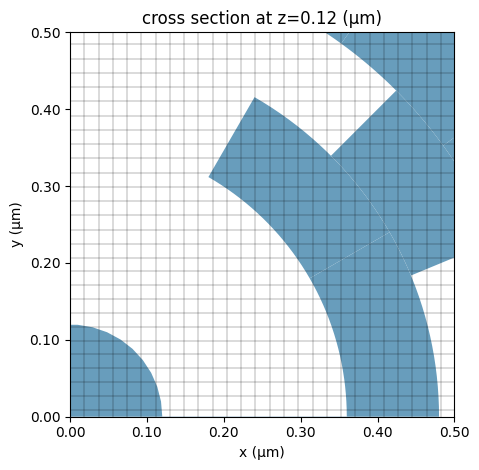

In [10]:
ax = sim.plot(z=h_wg / 2)
sim.plot_grid(z=h_wg / 2, ax=ax)
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
plt.show()

Define a function to postprocess the simulation data and calculate the objective function, which is given by 

$$
0.5 \times (\frac{T^{RCP}_L - T^{RCP}_R }{T^{RCP}_L} + \frac{T^{LCP}_R - T^{LCP}_L }{T^{LCP}_R}),
$$

where $T^{RCP}_L$ and $T^{LCP}_R$ are the transmission of the left and right waveguides under RCP and LCP excitations, respectively. Note that this objective function only maximizes the transmission difference between the two waveguides under RCP and LCP excitations, and does not consider the coupling efficiency and absolute transmission power.

In [11]:
def postprocess(sim_data_right, sim_data_left):
    """
    Post-processes simulation data to calculate the objective function value.

    Args:
        sim_data_right (td.SimulationData): Simulation data for right-circularly polarized (RCP) input.
        sim_data_left (td.SimulationData): Simulation data for left-circularly polarized (LCP) input.


    Returns:
        float: The calculated objective function value.
    """
    # Calculate the transmitted power for RCP input, detected as left-circularly polarized (LCP).
    T_RCP_L = np.abs(sim_data_right["mode_left"].amps.sel(direction="-").item()) ** 2
    # Calculate the transmitted power for RCP input, detected as right-circularly polarized (RCP).
    T_RCP_R = np.abs(sim_data_right["mode_right"].amps.sel(direction="+").item()) ** 2
    # Calculate the transmitted power for LCP input, detected as left-circularly polarized (LCP).
    T_LCP_L = np.abs(sim_data_left["mode_left"].amps.sel(direction="-").item()) ** 2
    # Calculate the transmitted power for LCP input, detected as right-circularly polarized (RCP).
    T_LCP_R = np.abs(sim_data_left["mode_right"].amps.sel(direction="+").item()) ** 2

    # Calculate the final metric based on the transmitted powers.
    return 0.5 * ((T_RCP_L - T_RCP_R) / T_RCP_L + (T_LCP_R - T_LCP_L) / T_LCP_R)

## Design Optimization

To perform the design optimization, we first generate a set of random designs and calculate the objective function for each design. Then we pick the best design and perform a DBS.

In [12]:
n_designs = 20  # Number of initial designs

# Generate random design parameters
rng = np.random.default_rng(seed=42)
design_params_history = rng.integers(0, 2, size=(n_designs, n_pixel))

# Create simulations
sims = {
    f"{i}_{pol}": sim
    for i, design in enumerate(design_params_history)
    for pol, sim in zip(("right", "left"), make_sims(design))
}

# Run simulations
batch = web.Batch(simulations=sims, verbose=False)
batch_results = batch.run(path_dir="data")

In [13]:
# Calculate the objective function for all designs
fom_history = [
    postprocess(batch_results[f"{i}_right"], batch_results[f"{i}_left"]) for i in range(n_designs)
]

# Pick the best design
max_fom = max(fom_history)
idx = fom_history.index(max_fom)
current_best_params = design_params_history[idx]
print(f"The {idx}-th sample has the maximum objective value of {max_fom:.4f}.")

The 16-th sample has the maximum objective value of 0.3477.


Now we are ready to perform DBS. Starting from an initial design, it iteratively flips individual bits, keeps changes that improve the objective function, and rejects those that do not. The pixels are visited in a randomized order to reduce traversal bias, and the process repeats for multiple passes until no further improvement is found or a specified objective threshold is reached.

In [14]:
def obj_func(design_params):
    """
    Objective function for optimization.

    Args:
        design_params (np.array): The design parameters.

    Returns:
        float: The objective value.
    """

    sim_right, sim_left = make_sims(design_params)
    batch = web.Batch(simulations={"right": sim_right, "left": sim_left}, verbose=False)
    batch_results = batch.run(path_dir="data")
    return postprocess(batch_results["right"], batch_results["left"])


def direct_binary_search(obj_func, initial_params, termination, max_passes=3):
    """
    Performs Direct Binary Search (DBS) to maximize the objective function.

    Args:
        obj_func (callable): The objective function to maximize.
        initial_design (np.array): The starting binary design vector.
        termination (float): Optimization termination condition
        max_passes (int): Maximum number of full passes over all pixels.

    Returns:
        best_design (np.array): The optimized binary array.
        best_objective (float): The corresponding function value.
    """

    current_design = initial_params.copy().astype(int)

    # Calculate initial objective
    current_objective = obj_func(current_design)
    best_design = current_design.copy()
    best_objective = current_objective

    n_params = len(current_design)

    print(f"Starting DBS. Parameters: {n_params}, Initial objective: {current_objective:.4f}")

    np.random.seed(123)
    for pass_num in range(max_passes):
        improved_in_this_pass = False

        # Create a random order of indices to visit (stochastic traversal prevents bias)
        indices = np.random.permutation(n_params)

        for idx in indices:
            # Flip the bit (0->1 or 1->0)
            current_design[idx] = 1 - current_design[idx]

            # Evaluate new design
            new_objective = obj_func(current_design)

            # Decision Logic
            if new_objective > current_objective:
                # Keep the change
                current_objective = new_objective
                best_design = current_design.copy()
                best_objective = new_objective
                improved_in_this_pass = True

                print(
                    f"  [Pass {pass_num + 1}] Improved! Idx {idx}: {1 - current_design[idx]}->{current_design[idx]} | Highest objective value: {new_objective:.4f}"
                )

                if new_objective >= termination:
                    print(
                        f"Termination condition reached (objective={new_objective:.4f} ≥ 0.99). Stopping optimization."
                    )
                    return best_design, best_objective

            else:
                # Revert the change
                current_design[idx] = 1 - current_design[idx]

        # Convergence check
        if not improved_in_this_pass:
            print(f"Converged at pass {pass_num + 1}. No further improvements found.")
            break

    return best_design, best_objective

Running the optimization and obtaining the final design.

In [15]:
print("Optimization Starting...")
optimized_design, final_objective = direct_binary_search(
    obj_func, current_best_params, termination=0.99
)

print("-" * 30)
print("Optimization Complete.")

Optimization Starting...
Starting DBS. Parameters: 435, Initial objective: 0.3477
  [Pass 1] Improved! Idx 319: 1->0 | Highest objective value: 0.4293
  [Pass 1] Improved! Idx 373: 0->1 | Highest objective value: 0.4333
  [Pass 1] Improved! Idx 189: 0->1 | Highest objective value: 0.4983
  [Pass 1] Improved! Idx 212: 1->0 | Highest objective value: 0.5031
  [Pass 1] Improved! Idx 232: 1->0 | Highest objective value: 0.5213
  [Pass 1] Improved! Idx 185: 0->1 | Highest objective value: 0.6802
  [Pass 1] Improved! Idx 75: 0->1 | Highest objective value: 0.6975
  [Pass 1] Improved! Idx 114: 1->0 | Highest objective value: 0.7368
  [Pass 1] Improved! Idx 36: 0->1 | Highest objective value: 0.8089
  [Pass 1] Improved! Idx 276: 1->0 | Highest objective value: 0.8198
  [Pass 1] Improved! Idx 9: 1->0 | Highest objective value: 0.8335
  [Pass 1] Improved! Idx 242: 0->1 | Highest objective value: 0.8394
  [Pass 1] Improved! Idx 287: 1->0 | Highest objective value: 0.8430
  [Pass 1] Improved! Idx 

We successfully achieved a PPS design with the objective function value larger than 0.99. We can visualize the final design pattern and export a gds file for fabrication.

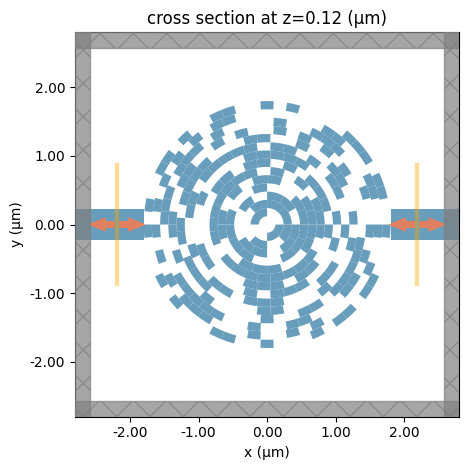

In [16]:
sim, _ = make_sims(optimized_design)
sim.plot(z=h_wg / 2)
plt.show()

sim.to_gds_file("./misc/optimized_spin_selector.gds", z=h_wg / 2)